In [1]:
import pandas as pd # used to load individual files
import numpy as np # not currently used
import datetime as dt # not currently used
#from geopy.distance import geodesic might be used at some point
#import peartree as pt # used to construct network
import matplotlib.pyplot as plt
import osmnx as ox # visualisation library for networks
%matplotlib inline
import pickle
import networkx as nx
import geopandas as gp
from collections import defaultdict
from geopy.distance import geodesic
from tqdm import tqdm
from sklearn.neighbors import BallTree
import math

c:\Users\Johan\Anaconda3\envs\gds_py\lib\site-packages\osmnx\projection.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
with open('rejsekort_graph_cleaned.gpickle', 'rb') as f:
    G = pickle.load(f)

In [3]:
G.nodes['000000000002']

{'boarding_cost': 1681.8,
 'modes': ['3'],
 'y': 55.767248497366,
 'x': 12.498017540594}

In [53]:
node_attributes = {
    "node_id":list(G.nodes()),
    "longitude":[G.nodes[node]['x'] for node in G.nodes()],
    "latitude":[G.nodes[node]['y'] for node in G.nodes()],
    "modes":[G.nodes[node]['modes'] for node in G.nodes()],
}
edge_attributes = {
    "source": [u for u, v in G.edges()],
    "target": [v for u, v in G.edges()],
    "length": [attr['length'] for u, v, attr in G.edges(data=True)],
    "mode": [attr["mode"] for u, v, attr in G.edges(data=True)],
}

In [66]:
nodes_df = gp.GeoDataFrame.from_dict(node_attributes)
nodes_df.geometry = gp.points_from_xy(nodes_df.longitude, nodes_df.latitude)
edges_df = gp.GeoDataFrame.from_dict(edge_attributes)


In [55]:
nodes_df

,node_id,longitude,latitude,modes,geometry
0,000000000002,12.498018,55.767248,[3],POINT (12.49802 55.76725)
1,000000000003,12.496648,55.764419,[3],POINT (12.49665 55.76442)
2,000000000006,12.494925,55.756223,[700],POINT (12.49492 55.75622)
3,000000000008,12.495169,55.749868,[700],POINT (12.49517 55.74987)
4,000000000009,12.494961,55.747366,"[3, 700]",POINT (12.49496 55.74737)
...,...,...,...,...,...
38167,000430264100,10.356677,55.172085,[3],POINT (10.35668 55.17209)
38168,000000036929,11.622673,55.371108,[3],POINT (11.62267 55.37111)
38169,000420613200,10.195897,55.388963,[3],POINT (10.19590 55.38896)
38170,000430477800,10.460308,55.216327,[3],POINT (10.46031 55.21633)


In [61]:
shapefile = "kommuneinddeling/kommuneinddeling.shp"
regions_df = gp.read_file(shapefile)
print(regions_df.crs)
# nodes_df.crs = "EPSG:4326"
# nodes_df.crs = "epsg:25832"
# nodes_df.to_crs(crs=regions_df.crs, inplace=True)
# regions_df.to_crs(crs=nodes_df.crs, inplace=True)
print(regions_df.crs)


epsg:25832
epsg:25832


In [67]:
crs_candidates = ["EPSG:4326"]
for cand in crs_candidates:
    nodes_df.crs = cand
    nodes_df.to_crs(crs=regions_df.crs, inplace=True)
    nodes_with_regions = gp.sjoin(nodes_df, regions_df, how="left", op="within")
    print(nodes_with_regions.objectid.isna().sum())

82


c:\Users\Johan\Anaconda3\envs\gds_py\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [68]:
nodes_df.crs

<Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.01, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [41]:
nodes_with_regions = gp.sjoin(nodes_df, regions_df, how="left", op="within")

c:\Users\Johan\Anaconda3\envs\gds_py\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [69]:
nodes_with_regions.head()

,node_id,longitude,latitude,modes,geometry,index_right,objectid,id_lokalid,id_namespa,status,...,dataspecif,landekode,skala,kommunekod,lau1vaerdi,udenforkom,regionskod,regionslok,udtraeksda,gmlid
0,000000000002,12.498018,55.767248,[3],POINT (719423.000 6185716.000),22.0,1256675,389115,http://data.gov.dk/dagi,vedtaget,...,DAGI Objektspecifikation version 2.0,DK,1:10.000,0173,173,f,1084,389099,2020-04-20,dagi.389115
1,000000000003,12.496648,55.764419,[3],POINT (719353.000 6185397.000),22.0,1256675,389115,http://data.gov.dk/dagi,vedtaget,...,DAGI Objektspecifikation version 2.0,DK,1:10.000,0173,173,f,1084,389099,2020-04-20,dagi.389115
2,000000000006,12.494925,55.756223,[700],POINT (719291.000 6184480.000),27.0,1255981,389109,http://data.gov.dk/dagi,vedtaget,...,DAGI Objektspecifikation version 2.0,DK,1:10.000,0159,159,f,1084,389099,2020-04-20,dagi.389109
3,000000000008,12.495169,55.749868,[700],POINT (719342.000 6183774.000),27.0,1255981,389109,http://data.gov.dk/dagi,vedtaget,...,DAGI Objektspecifikation version 2.0,DK,1:10.000,0159,159,f,1084,389099,2020-04-20,dagi.389109
4,000000000009,12.494961,55.747366,"[3, 700]",POINT (719343.000 6183495.000),27.0,1255981,389109,http://data.gov.dk/dagi,vedtaget,...,DAGI Objektspecifikation version 2.0,DK,1:10.000,0159,159,f,1084,389099,2020-04-20,dagi.389109


In [32]:
regions_df.head()

,objectid,id_lokalid,id_namespa,status,geometrist,virkningfr,virkningti,virkningsa,forretning,registreri,...,landekode,skala,kommunekod,lau1vaerdi,udenforkom,regionskod,regionslok,udtraeksda,gmlid,geometry
0,1284412,389183,http://data.gov.dk/dagi,vedtaget,endelig,20181102000000,None,Geodatastyrelsen,matrikulærAjourføring,20181102081410.437,...,DK,1:10.000,0665,665,f,1082,389101,2020-04-20,dagi.389183,MULTIPOLYGON Z (((446115.180 6250956.630 0.000...
1,1284617,389199,http://data.gov.dk/dagi,vedtaget,endelig,20181107000000,None,Geodatastyrelsen,matrikulærAjourføring,20181107121715.346,...,DK,1:10.000,0810,810,f,1081,389098,2020-04-20,dagi.389199,"POLYGON Z ((556389.890 6342937.290 0.000, 5563..."
2,1284619,389206,http://data.gov.dk/dagi,vedtaget,endelig,20181107000000,None,Geodatastyrelsen,matrikulærAjourføring,20181107121715.346,...,DK,1:10.000,0851,851,f,1081,389098,2020-04-20,dagi.389206,MULTIPOLYGON Z (((557400.690 6323373.320 0.000...
3,1284689,389175,http://data.gov.dk/dagi,vedtaget,endelig,20181108000000,None,Geodatastyrelsen,FOTAjourføring,20181108130916.952,...,DK,1:10.000,0607,607,f,1083,389102,2020-04-20,dagi.389175,MULTIPOLYGON Z (((537517.320 6152061.430 0.000...
4,1287002,389140,http://data.gov.dk/dagi,vedtaget,endelig,20190101000000,None,Geodatastyrelsen,matrikulærAjourføring,20190107122901.497,...,DK,1:10.000,0316,316,f,1085,389100,2020-04-20,dagi.389140,MULTIPOLYGON Z (((674151.550 6184820.700 0.000...


<Axes: >

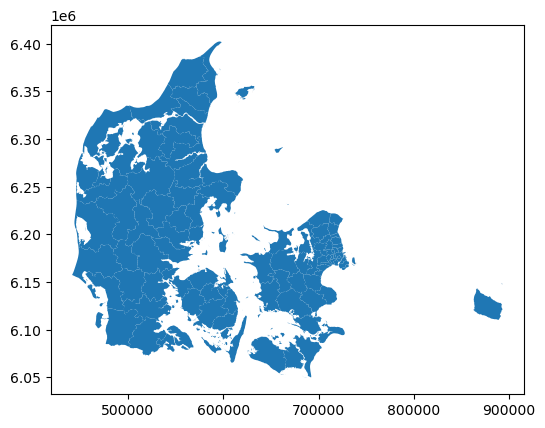

In [43]:
regions_df.plot()

<Axes: >

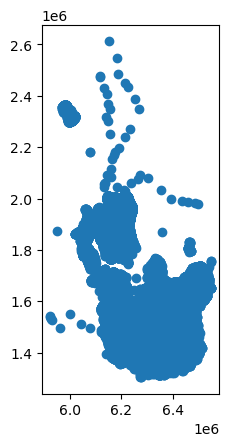

In [44]:
nodes_df.plot()